In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [22]:
class Poly_Regression:
    def __init__(self, l=1, m=1, k=1):
        self.l = l
        self.m = m
        self.k = k
        # self.n = n
        
        # self.X = None
        # self.y = None
        self.B = None
    
    # Converting given data array for x into disired format with three dimensions
    def X_poly(self, X):
        n = X.shape[0]
        powers = np.arange(1, self.m+1)
        # X = X.reshape(n, self.l)
        # X3d = X[:, :, np.newaxis] ** powers[np.newaxis, np.newaxis, :]
        # print(X.shape)
        X3d = X.reshape(n, self.l, 1) ** powers.reshape(1, 1, self.m)
        X3d = np.concatenate((np.ones((n,1)), X3d.reshape(n, self.l*self.m)), axis=1)
        return X3d
    
    def train(self, X_train, y_train):
        n = X_train.shape[0]
        X_flat = self.X_poly(X_train)
        y = y_train.reshape(n, self.k)
        
        # X_flat = X.reshape(n, self.l*self.m)
        
        # B_flat = np.matmul(np.linalg.inv(np.matmul(X_flat.T, X_flat)), np.matmul(X_flat.T, y))
        # self.B = np.concatenate((B_flat[0,:].reshape(self.l, 1, self.k), B_flat[1:,:].reshape(self.l, self.m, self.k)), axis = 1)
        self.B = np.matmul(np.linalg.inv(np.matmul(X_flat.T, X_flat)), np.matmul(X_flat.T, y))
    
    def make_predictions(self, X):
        n = X.shape[0]
        X_flat = self.X_poly(X)
        # X_flat = X.reshape(n, self.l*self.m)
        # B_flat = self.B.reshape(self.l*(self.m+1), self.k)
        return np.matmul(X_flat, self.B)
    
    def MSE(self, X_test, y_test):
        y_predicted = self.make_predictions(X_test)
        y_test = y_test.reshape(y_predicted.shape)
        return np.mean(((y_predicted - y_test)**2), axis=0)
    
    def SSR(self, X_test, y_test):
        y_predicted = self.make_predictions(X_test)
        y_test = y_test.reshape(y_predicted.shape)
        return np.sum(((y_predicted - y_test)**2), axis=0)
    
    def Rsquared(self, X_test, y_test):
        y_predicted = self.make_predictions(X_test)
        y_test = y_test.reshape(y_predicted.shape)
        Syy = np.sum(((y_test - np.mean(y_test, axis=0))**2), axis=0)
        SSr = self.SSR(X_test, y_test)
        return 1 - SSr/Syy
    
    def MAE(self, X_test, y_test):
        y_predicted = self.make_predictions(X_test)
        y_test = y_test.reshape(y_predicted.shape)
        return np.mean((np.abs(y_predicted - y_test)), axis=0)

In [23]:
training_data = pd.read_csv('train.csv')
training_data = training_data.sort_values(by='x')
test_data = pd.read_csv('test.csv')
X_train = np.array(training_data['x'])
X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
X_test = np.array(test_data['x'])
X_test = (X_test-np.min(X_test))/(np.max(X_test)-np.min(X_train))
y_train = np.array(training_data['y'])

## Part 3(a)

We are training the model for $m=5$, as will become clear through further parts

In [28]:
pred_model = Poly_Regression(l=1, k=1, m=5)
pred_model.train(X_train, y_train)
B = pred_model.B
with open("3_weights.pkl", 'wb')as f:
    pickle.dump(B, f)
y_test_pred = pred_model.make_predictions(X_test)
test_data['y'] = y_test_pred
test_data.to_csv('3_predictions.csv', index=False)

## Part 3(b)

#### Cross-validation for finding optimal m

In [25]:
model_fit = Poly_Regression(l=1, k=1)
final_m = 1
final_B = None
final_MSE = np.inf
for j in [5,8,10,16,20,25,40,50,80,100]:
    # Splitting the traiining dataset into sub-data of size j each
    Train_split = np.array(training_data[['x', 'y']].to_numpy()).reshape(j, -1, 2)
    X_fit_train_mse = []
    X_fit_test_mse = []
    Optimal_B = []
    for i in np.arange(1, 50):
        model_fit.m = i
        optimal_B = None
        optimal_train_mse = []
        optimal_test_mse = []
        # Now we select all the sub-data of the splitted training dataset one-by-one as the test dataset in this loop
        for Fit_test in Train_split:
            Fit_train = np.array([row for row in Train_split if not np.array_equal(row, Fit_test)]).reshape(-1,2)
            X_fit_train = Fit_train[:,0]
            y_fit_train = Fit_train[:,1]
            X_fit_test = Fit_test[:,0]
            y_fit_test = Fit_test[:,1]
            
            model_fit.train(X_train=X_fit_train, y_train=y_fit_train)
            MSE_train = model_fit.MSE(X_fit_train, y_fit_train)
            MSE_test = model_fit.MSE(X_fit_test, y_fit_test)
            optimal_test_mse.append(MSE_test)
            optimal_train_mse.append(MSE_train)
            optimal_B = model_fit.B
        X_fit_train_mse.append(np.mean(optimal_train_mse))
        X_fit_test_mse.append(np.mean(optimal_test_mse))
        Optimal_B.append(optimal_B)
    print(f"nFolds={j}\tm={np.argmin(X_fit_test_mse)}\tMSE_train={np.min(X_fit_train_mse)}\tMSE_test={np.min(X_fit_test_mse)}")

nFolds=5	m=5	MSE_train=556.8041432165935	MSE_test=981.5587847718405
nFolds=8	m=4	MSE_train=557.5654030941809	MSE_test=816.8126235875246
nFolds=10	m=4	MSE_train=554.9436647654804	MSE_test=683.9333132322299
nFolds=16	m=5	MSE_train=555.3528335604082	MSE_test=639.5206521085473
nFolds=20	m=4	MSE_train=554.6543694714767	MSE_test=616.8746116051427
nFolds=25	m=4	MSE_train=555.0543187003107	MSE_test=611.7018569178714
nFolds=40	m=4	MSE_train=555.4656748878895	MSE_test=608.0246934237405
nFolds=50	m=4	MSE_train=555.4495153782241	MSE_test=606.8300787202393
nFolds=80	m=4	MSE_train=555.6131851614095	MSE_test=608.2672008621819
nFolds=100	m=4	MSE_train=555.8036722450887	MSE_test=604.7099643768886


We can clearly see that $m=4$ is the optimal value of degree

For m=1, MSE_train=[933.11318797]
For m=1, MSE_test=[7873.31140025]


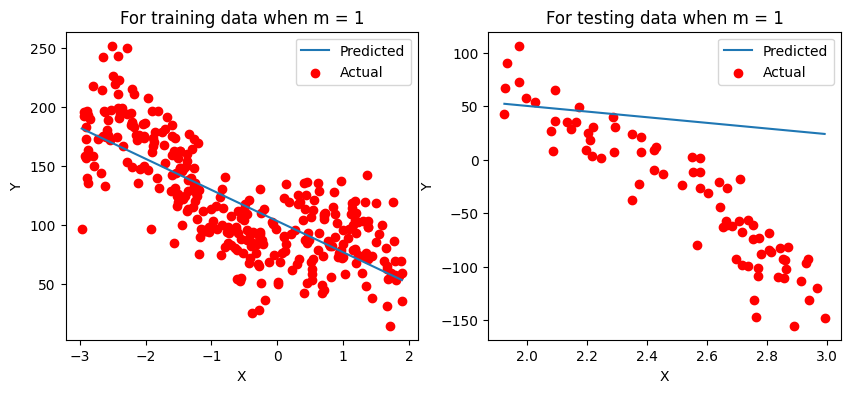

For m=2, MSE_train=[808.90657099]
For m=2, MSE_test=[18559.47048794]


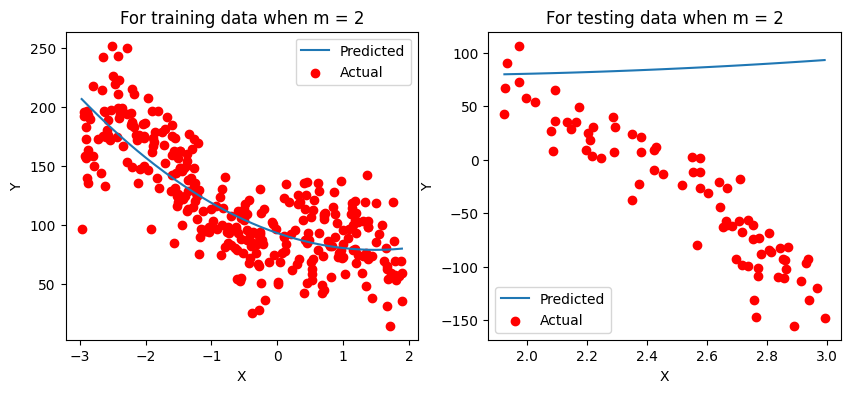

For m=3, MSE_train=[801.1334608]
For m=3, MSE_test=[26370.90641956]


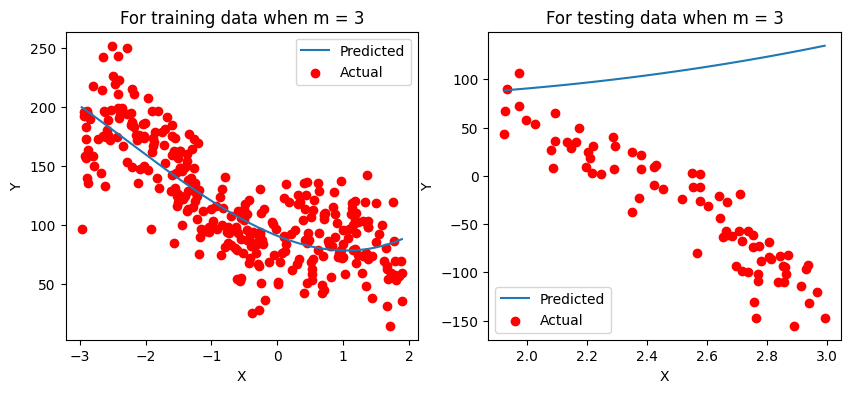

For m=4, MSE_train=[610.756592]
For m=4, MSE_test=[14018.50697749]


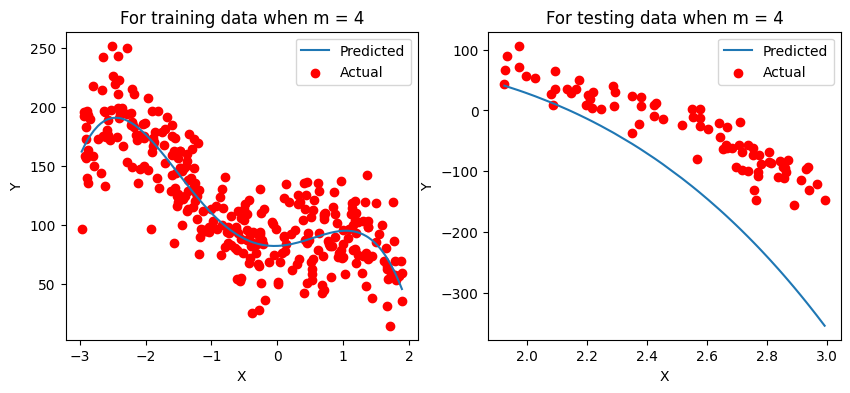

For m=5, MSE_train=[605.70619144]
For m=5, MSE_test=[813.89439735]


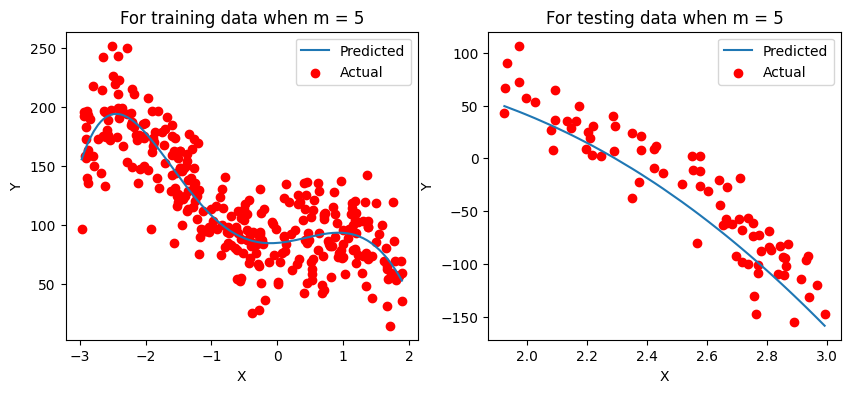

For m=6, MSE_train=[605.6991525]
For m=6, MSE_test=[625.80032039]


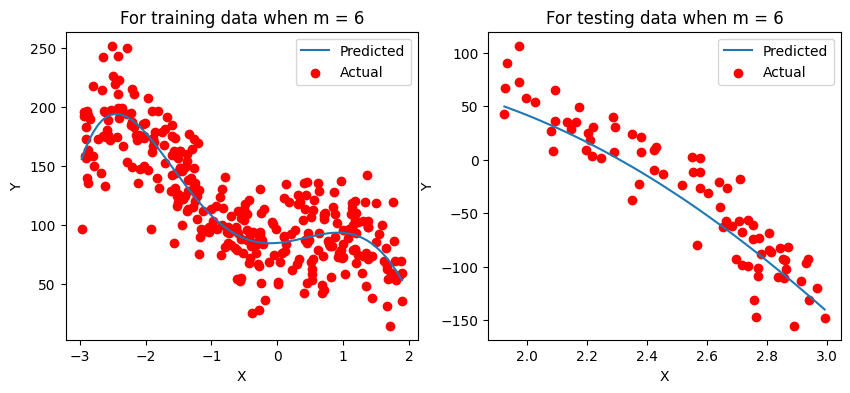

For m=7, MSE_train=[604.82575362]
For m=7, MSE_test=[50978.51647412]


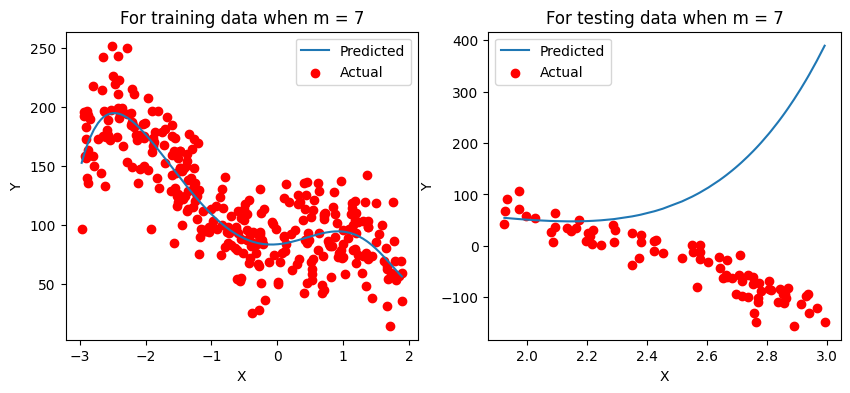

For m=8, MSE_train=[602.97380246]
For m=8, MSE_test=[288532.83445132]


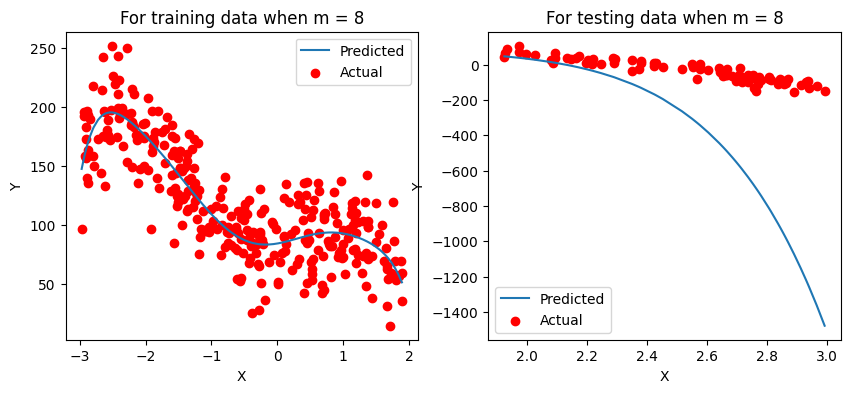

For m=9, MSE_train=[602.70538101]
For m=9, MSE_test=[15250.18343503]


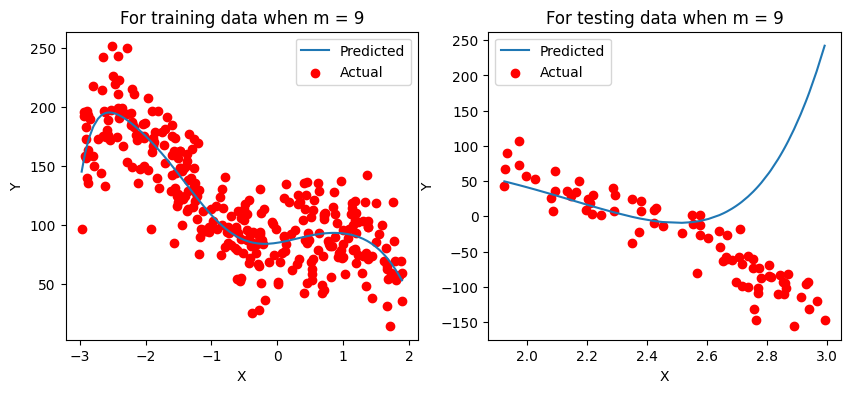

For m=10, MSE_train=[598.97122725]
For m=10, MSE_test=[33288970.37335391]


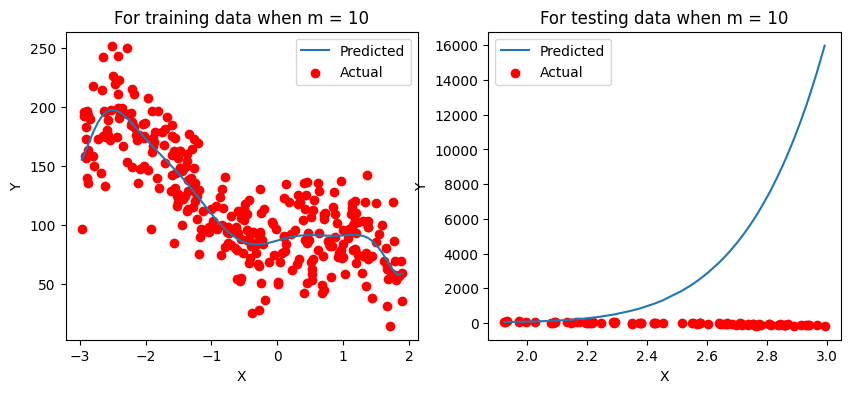

For m=11, MSE_train=[598.83094742]
For m=11, MSE_test=[70108773.78127918]


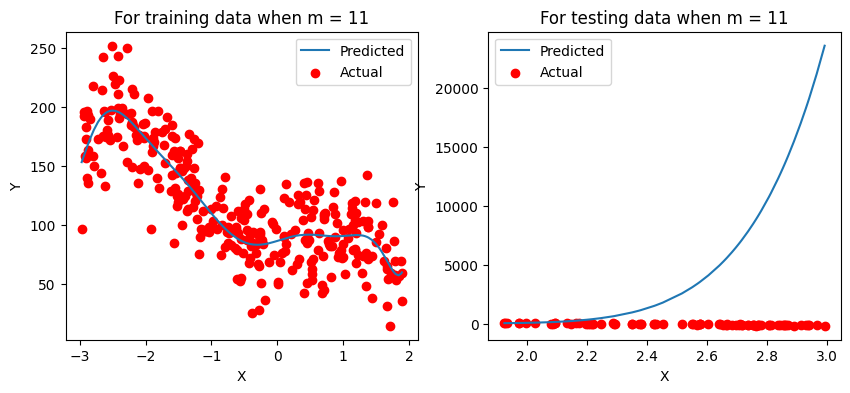

For m=12, MSE_train=[597.20512215]
For m=12, MSE_test=[1.7408157e+08]


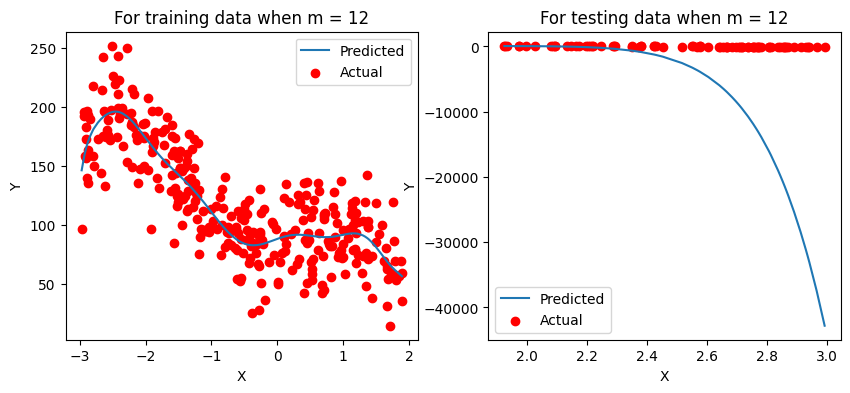

For m=13, MSE_train=[597.0175465]
For m=13, MSE_test=[19808310.77735328]


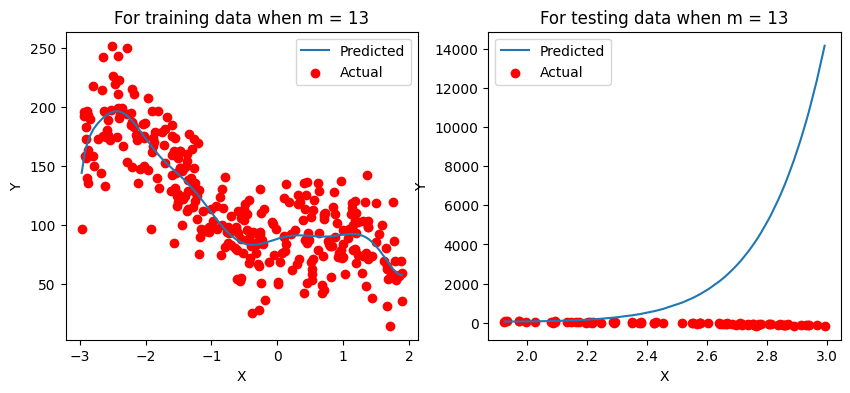

For m=14, MSE_train=[583.77112359]
For m=14, MSE_test=[1.21829647e+11]


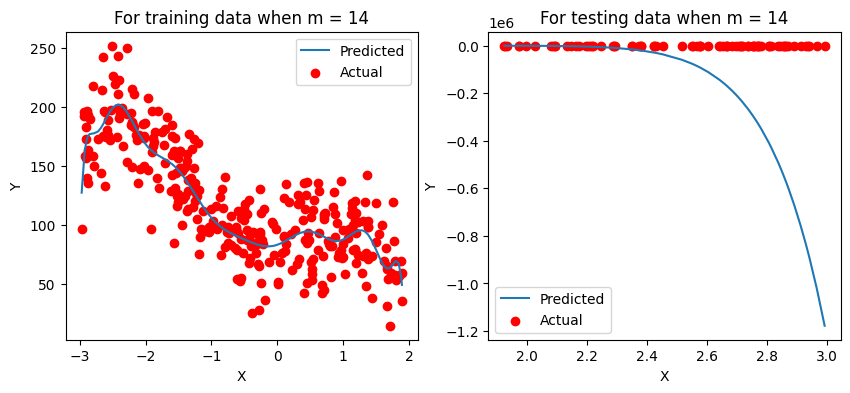

For m=15, MSE_train=[577.83228464]
For m=15, MSE_test=[4.86062263e+10]


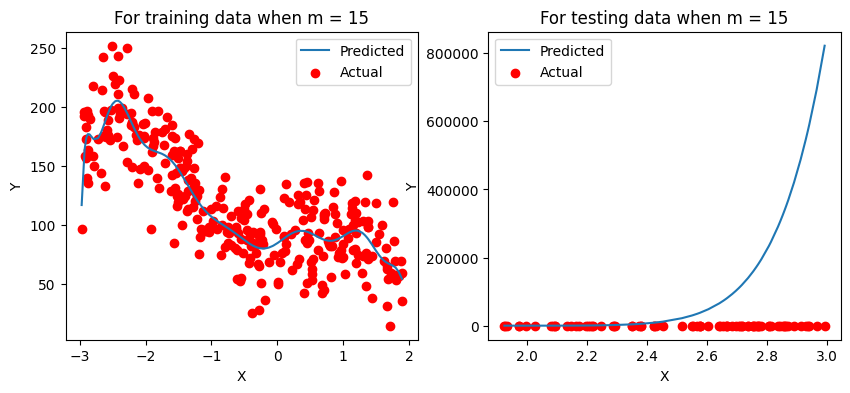

For m=16, MSE_train=[576.11455246]
For m=16, MSE_test=[2.7507673e+11]


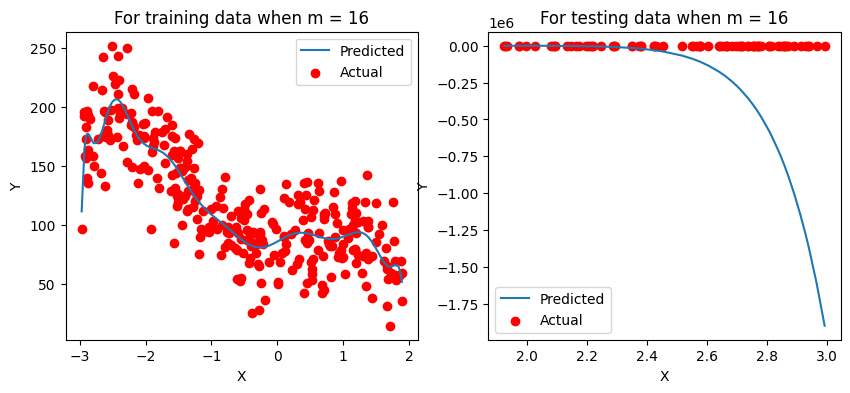

For m=17, MSE_train=[577.30008994]
For m=17, MSE_test=[1.02679694e+12]


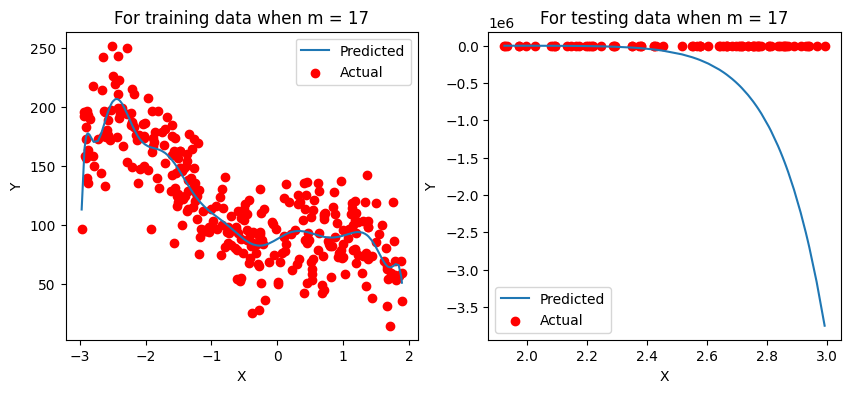

For m=18, MSE_train=[713.18241389]
For m=18, MSE_test=[6.04267213e+13]


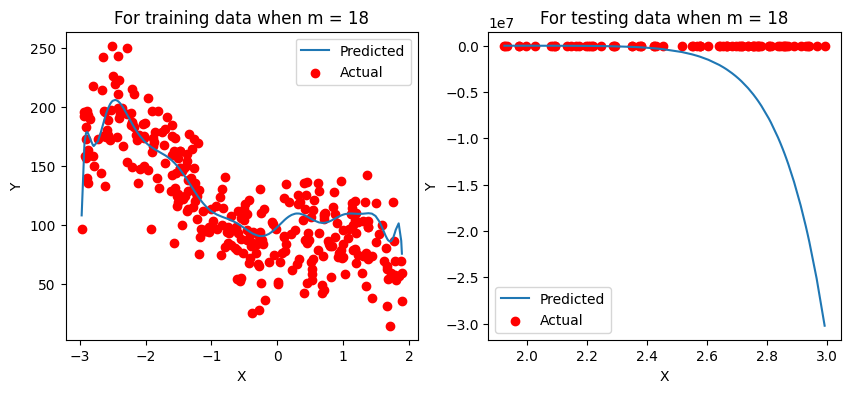

For m=19, MSE_train=[35987.9663758]
For m=19, MSE_test=[1.01038795e+14]


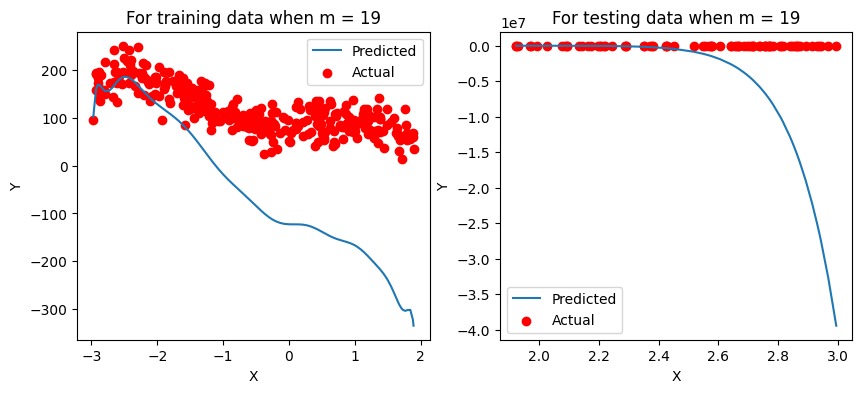

In [26]:
Train_split = np.array(training_data[['x', 'y']].to_numpy()).reshape(5, -1, 2)
Fit_test = Train_split[-1]
Fit_train = np.array([row for row in Train_split if not np.array_equal(row, Fit_test)]).reshape(-1,2)
X_fit_train = Fit_train[:,0]
y_fit_train = Fit_train[:,1]
X_fit_test = Fit_test[:,0]
y_fit_test = Fit_test[:,1]

for m in np.arange(1,20):
    model = Poly_Regression(l=1, k=1, m=m)
    model.train(X_fit_train, y_fit_train)
    y_train_pred = model.make_predictions(X_fit_train)
    y_test_pred = model.make_predictions(X_fit_test)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    print(f"For m={m}, MSE_train={model.MSE(X_fit_train, y_fit_train)}")
    print(f"For m={m}, MSE_test={model.MSE(X_fit_test, y_fit_test)}")
    axs[0].plot(X_fit_train, y_train_pred, label="Predicted")
    axs[0].scatter(X_fit_train, y_fit_train, label="Actual", color='r')
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].legend()
    axs[0].set_title(f"For training data when m = {m}")
    
    axs[1].plot(X_fit_test, y_test_pred, label="Predicted")
    axs[1].scatter(X_fit_test, y_fit_test, label="Actual", color='r')
    axs[1].set_xlabel("X")
    axs[1].set_ylabel("Y")
    axs[1].legend()
    axs[1].set_title(f"For testing data when m = {m}")
    if m==5:
        plt.savefig('3_correctfit.png')
    if m==3:
        plt.savefig('3_underfit.png')
    if m==7:
        plt.savefig('3_overfit.png')
    plt.show()

From the plots, we can infer that the most accurate fits without any overfits or underfits occur for $m=4$ to $6$, but since our cross validation gave us the least mean squared error for $m=4$ and considering the fact that the graphs strongly point that we should choose $m=6$, we will go with<br>
**Correct Fit:**    $m = 5$<br>
**Underfit:**       $m < 4$ (say $m=3$)<br>
**Overfit:**        $m > 6$ (say $m=9$)

## Part 3(c)

In [27]:
model_underfit = Poly_Regression(m=3, l=1, k=1)
model_underfit.train(X_train, y_train)
print(f"For Underfit Model, with m=3:\n\tMean Squared Error MSE: {model_underfit.MSE(X_train, y_train)}\n\tSum of Squared Errors SSr: {model_underfit.SSR(X_train, y_train)}\n\tRsquared: {model_underfit.Rsquared(X_train, y_train)}")

model_correctfit = Poly_Regression(m=5, l=1, k=1)
model_correctfit.train(X_train, y_train)
print(f"For Correctfit Model, with m=5:\n\tMean Squared Error: {model_correctfit.MSE(X_train, y_train)}\n\tSum of Squared Errors SSr: {model_correctfit.SSR(X_train, y_train)}\n\tRsquared: {model_correctfit.Rsquared(X_train, y_train)}")

model_overfit = Poly_Regression(m=7, l=1, k=1)
model_overfit.train(X_train, y_train)
print(f"For Overfit Model, with m=7:\n\tMean Squared Error MSE: {model_overfit.MSE(X_train, y_train)}\n\tSum of Squared Errors SSr: {model_overfit.SSR(X_train, y_train)}\n\tRsquared: {model_overfit.Rsquared(X_train, y_train)}")

For Underfit Model, with m=3:
	Mean Squared Error MSE: [991.02440684]
	Sum of Squared Errors SSr: [396409.76273644]
	Rsquared: [0.84159226]
For Correctfit Model, with m=5:
	Mean Squared Error: [589.40039875]
	Sum of Squared Errors SSr: [235760.15949993]
	Rsquared: [0.90578881]
For Overfit Model, with m=7:
	Mean Squared Error MSE: [588.51592016]
	Sum of Squared Errors SSr: [235406.36806422]
	Rsquared: [0.90593019]
